# Wall Loss Tutorial: Spherical vs Rectangular Chambers

Learn how to configure wall loss strategies, compare chamber geometries,
and chain wall loss with coagulation and condensation. All examples run
quickly (≤30 s) with small grids and reuse helper functions to avoid
recomputing simulations.

## Setup
- Uses particula public APIs from `par.dynamics` re-exports.
- Time grid: 0–30 min with 30 s spacing (61 points).
- Distribution: preset discrete radius bins (small and fast).
- Plots: minutes on x-axis; log-scale concentrations.

In [1]:
import numpy as np
import particula as par
from matplotlib import pyplot as plt

np.set_printoptions(precision=3, suppress=True)
TIME_STEP = 30.0  # seconds
TOTAL_TIME = 1800.0  # seconds (30 minutes)
N_STEPS = int(TOTAL_TIME / TIME_STEP)
TIME_GRID = np.linspace(0.0, TOTAL_TIME, N_STEPS + 1)
TEMPERATURE = 298.15  # K
PRESSURE = 101325.0  # Pa

In [2]:
def build_aerosol() -> par.Aerosol:
    """Create a small discrete aerosol with an empty atmosphere."""
    particles = par.particles.PresetParticleRadiusBuilder().build()
    partitioning_species = par.gas.GasSpecies(
        name="PlaceholderPartitioning",
        molar_mass=0.018,
        partitioning=True,
        vapor_pressure_strategy=par.gas.ConstantVaporPressureStrategy(1e3),
    )
    gas_only_species = par.gas.GasSpecies(
        name="PlaceholderGasOnly",
        molar_mass=0.028,
        partitioning=False,
        vapor_pressure_strategy=par.gas.ConstantVaporPressureStrategy(1e3),
    )
    atmosphere = par.gas.Atmosphere(
        temperature=TEMPERATURE,
        total_pressure=PRESSURE,
        partitioning_species=partitioning_species,
        gas_only_species=gas_only_species,
    )
    return par.Aerosol(atmosphere=atmosphere, particles=particles)


def run_wall_loss(strategy: par.dynamics.WallLossStrategy, sub_steps: int = 1):
    """Execute wall loss over the shared time grid."""
    aerosol = build_aerosol()
    wall_loss = par.dynamics.WallLoss(wall_loss_strategy=strategy)
    series = np.zeros_like(TIME_GRID)
    series[0] = aerosol.particles.get_total_concentration()
    for idx in range(1, TIME_GRID.size):
        aerosol = wall_loss.execute(
            aerosol, time_step=TIME_STEP, sub_steps=sub_steps
        )
        series[idx] = aerosol.particles.get_total_concentration()
    return series, aerosol


def plot_decay(times_min, *series_with_labels):
    fig, ax = plt.subplots(figsize=(6, 4))
    for series, label, style in series_with_labels:
        ax.plot(times_min, series / series[0], style, label=label, linewidth=2)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Normalized concentration")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    return fig, ax


times_minutes = TIME_GRID / 60.0
baseline_aerosol = build_aerosol()
print("Initial bins:", baseline_aerosol.particles.get_radius().size)
print(
    "Initial total conc (1/m^3):",
    f"{baseline_aerosol.particles.get_total_concentration():.3e}",
)

Initial bins: 250
Initial total conc (1/m^3): 1.100e+10


## Basic spherical wall loss
Spherical chamber with modest eddy diffusivity and radius. Uses two
sub-steps to demonstrate clamping behavior in the runnable.

In [3]:
spherical_strategy = par.dynamics.SphericalWallLossStrategy(
    wall_eddy_diffusivity=1e-3,
    chamber_radius=0.5,
    distribution_type="discrete",
)
spherical_series, spherical_aerosol = run_wall_loss(
    spherical_strategy, sub_steps=2
)
print("Final conc (spherical):", f"{spherical_series[-1]:.3e} 1/m^3")

Final conc (spherical): 1.061e+10 1/m^3


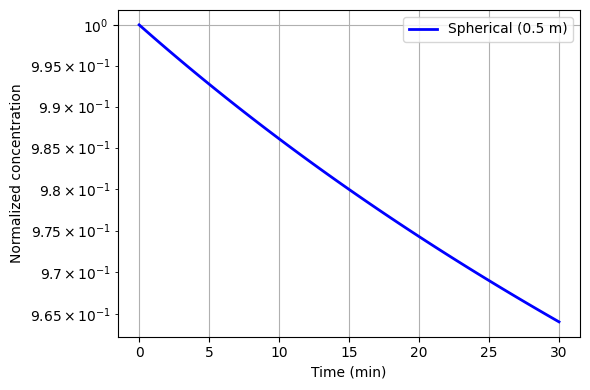

In [4]:
_ = plot_decay(
    times_minutes,
    (spherical_series, "Spherical (0.5 m)", "b-"),
)

## Geometry comparison: spherical vs rectangular
Equal-volume comparison: a 0.5 m radius sphere (~0.52 m^3) vs a rectangular
chamber with dimensions (1.0, 0.72, 0.72) m.

Text(0.5, 1.0, 'Geometry comparison')

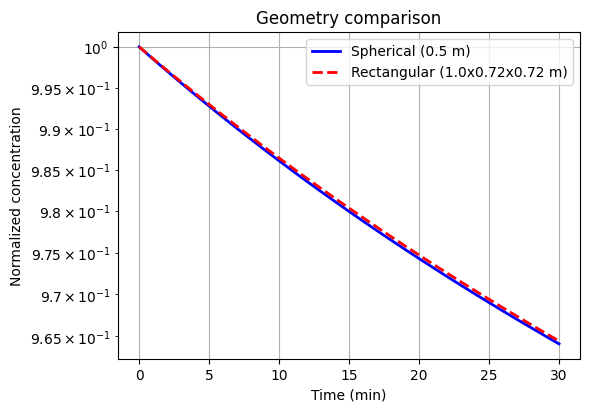

In [5]:
rectangular_strategy = par.dynamics.RectangularWallLossStrategy(
    wall_eddy_diffusivity=1e-3,
    chamber_dimensions=(1.0, 0.72, 0.72),
    distribution_type="discrete",
)
rect_series, _ = run_wall_loss(rectangular_strategy)
fig_cmp, _ = plot_decay(
    times_minutes,
    (spherical_series, "Spherical (0.5 m)", "b-"),
    (rect_series, "Rectangular (1.0x0.72x0.72 m)", "r--"),
)
fig_cmp.axes[0].set_title("Geometry comparison")

## Advanced chaining: coagulation + wall loss
Demonstrates runnable composition with the `|` operator. Uses the same time
    grid and small bin counts to keep runtime low.

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.60it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.17it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.33it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.28it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.83it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.94it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.72it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.32it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.87it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 56.49it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 56.29it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.59it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 61.03it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 57.51it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.91it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.26it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.94it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.73it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 61.20it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 56.89it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.17it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.91it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.68it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.34it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 57.31it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.48it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.39it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.94it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.64it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.49it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.96it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.33it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.27it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.87it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.91it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 56.18it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.58it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 57.52it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.87it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.72it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 57.58it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 61.30it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.87it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 61.25it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.11it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.07it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 61.87it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.93it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.05it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 58.36it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 60.17it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 61.34it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 59.29it/s]

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Executing Runnable: 100%|██████████| 1/1 [00:00<00:00, 61.99it/s]

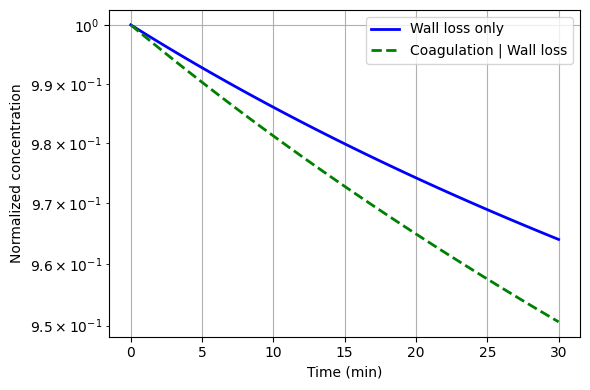

In [6]:
coag_strategy = par.dynamics.BrownianCoagulationStrategy(
    distribution_type="discrete"
)
coagulation = par.dynamics.Coagulation(coagulation_strategy=coag_strategy)
coag_wall = coagulation | par.dynamics.WallLoss(
    wall_loss_strategy=spherical_strategy
)

aerosol_wall_only = build_aerosol()
aerosol_coag_wall = build_aerosol()
wall_only_series = np.zeros_like(TIME_GRID)
coag_wall_series = np.zeros_like(TIME_GRID)
wall_only_series[0] = aerosol_wall_only.particles.get_total_concentration()
coag_wall_series[0] = aerosol_coag_wall.particles.get_total_concentration()

for idx in range(1, TIME_GRID.size):
    aerosol_wall_only = par.dynamics.WallLoss(
        wall_loss_strategy=spherical_strategy
    ).execute(aerosol_wall_only, time_step=TIME_STEP)
    aerosol_coag_wall = coag_wall.execute(
        aerosol_coag_wall, time_step=TIME_STEP
    )
    wall_only_series[idx] = (
        aerosol_wall_only.particles.get_total_concentration()
    )
    coag_wall_series[idx] = (
        aerosol_coag_wall.particles.get_total_concentration()
    )

_ = plot_decay(
    times_minutes,
    (wall_only_series, "Wall loss only", "b-"),
    (coag_wall_series, "Coagulation | Wall loss", "g--"),
)

### Concise condensation + wall loss snippet
Shows a lightweight condensation strategy chained with wall loss over a
short window (10 min). Parameters are intentionally small to keep runtime
≤1 s.

In [7]:
short_time = np.linspace(0.0, 600.0, 21)  # 10 min, 30 s spacing
cond_series = np.zeros_like(short_time)
try:
    condensation_strategy = par.dynamics.CondensationIsothermalBuilder()
    condensation_strategy.set_molar_mass(0.12, "kg/mol")
    condensation_strategy.set_diffusion_coefficient(1e-5, "m^2/s")
    condensation_strategy.set_accommodation_coefficient(0.9)
    condensation_strategy.set_update_gases(False)
    condensation = par.dynamics.MassCondensation(
        condensation_strategy=condensation_strategy.build()
    )
    wall_loss_runnable = par.dynamics.WallLoss(
        wall_loss_strategy=spherical_strategy
    )
    cond_wall = condensation | wall_loss_runnable

    aerosol_cond = build_aerosol()
    cond_series[0] = aerosol_cond.particles.get_total_concentration()

    for idx in range(1, short_time.size):
        aerosol_cond = cond_wall.execute(
            aerosol_cond, time_step=short_time[1] - short_time[0]
        )
        cond_series[idx] = aerosol_cond.particles.get_total_concentration()

    _ = plot_decay(
        short_time / 60.0,
        (cond_series, "Condensation | Wall loss (10 min)", "m-"),
    )
except ValueError as exc:
    print(f"Skipping condensation wall loss snippet: {exc}")

Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kyle/Code/particula/trees/ab7f6fe3/particula/particles/distribution_strategies/radii_based_moving_bin.py:69: RuntimeWarning: invalid value encountered in power
  new_radii = np.power(3 * new_volumes / (4 * np.pi), 1 / 3)


Executing Runnable:   0%|          | 0/1 [00:00<?, ?it/s]

Skipping condensation wall loss snippet: Argument 'particle_radius' must be finite (no inf or NaN).


## Assertions and sanity checks
Quick guards to keep the notebook honest during headless execution.

In [8]:
# Geometry parameter validation
try:
    par.dynamics.SphericalWallLossStrategy(
        wall_eddy_diffusivity=1e-3, chamber_radius=-1.0
    )
    raise AssertionError("Expected ValueError for negative radius")
except ValueError:
    pass

try:
    par.dynamics.RectangularWallLossStrategy(
        wall_eddy_diffusivity=1e-3, chamber_dimensions=(0.0, 1.0, 1.0)
    )
    raise AssertionError("Expected ValueError for non-positive dimension")
except ValueError:
    pass

# Concentration non-negativity after simulations
for name, series in [
    ("spherical", spherical_series),
    ("rectangular", rect_series),
    ("wall only", wall_only_series),
    ("coagulation | wall", coag_wall_series),
    ("condensation | wall", cond_series),
]:
    if not np.all(series >= 0.0):
        raise AssertionError(f"Non-negative concentrations failed for {name}")

print("Assertions passed: parameter guards and non-negativity checks.")

Assertions passed: parameter guards and non-negativity checks.


## Summary
- Built reusable helpers to construct aerosols and run wall loss quickly.
- Compared spherical vs rectangular chambers over a shared time grid.
- Demonstrated chaining with coagulation and a concise condensation variant.
- Added inline assertions for invalid geometry and non-negative concentrations.